## Target:

1. Get the set-up right
2. Set Transforms
3. Set Data Loader
4. Set Basic skeleton
5. Made model lighter

## Results:
1. Parameters: 62k
2. Best Training Accuracy: 99.04
3. Best Test Accuracy: 99.03

##Analysis:

1. Heavy Model for such a problem
2. Model is over-fitting at some steps although the gap is reduced

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 272211710.92it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 59555405.03it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 82707176.56it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16888766.64it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(0.1)
        # Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=1, padding=1, bias=False),  #28>>28 | 1>>3 | 1>>1
            nn.ReLU(),
            #nn.BatchNorm2d(4),
            nn.Conv2d(4, 4, 3, stride =1,padding=1, bias=False),  #28>>28 | 3>>5 | 1>>1
            nn.ReLU(),
            #nn.BatchNorm2d(4),
            nn.Conv2d(4, 8, 3, stride=1, padding=1, bias=False),#28>>28 | 5>>7 | 1>>1
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),#28>>14 | 7>>8 | 1>>2
            #nn.Dropout(0.25)
        )
        # Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1, bias=False),#14>>14 | 8>>12 | 2>>2
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1, bias=False), #14>>14 | 12>>16 | 2>>2
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False),#14>>14 | 16>>20 | 2>>2
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),#14>>7 | 20>>22 | 2>>4
            #nn.Dropout(0.25)
        )
        # Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, bias=False),#7>>7 | 22>>30 | 4>>4
            nn.Conv2d(64, 1, 1, stride=1, padding=1, bias=False), #7>>9 | 30>>30 | 4>>4
            nn.ReLU(),
            #nn.BatchNorm2d(128),
            #nn.MaxPool2d(2, 2),
            #nn.Dropout(0.25)
        )

        self.fc = nn.Sequential(
            nn.Linear(81, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.norm4(x)
        #print('SIze', x.size)
        #x = x.view(-1, 3200)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        #x = self.gpool(x)
        #x = x.view(-1, 10)
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              36
              ReLU-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 4, 28, 28]             144
              ReLU-4            [-1, 4, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             288
              ReLU-6            [-1, 8, 28, 28]               0
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           1,152
              ReLU-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           4,608
             ReLU-11           [-1, 32, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          18,432
             ReLU-13           [-1, 64, 14, 14]               0
        MaxPool2d-14             [-1, 6

<ipython-input-13-2e2ba87c84c2>:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
num_epochs = 19
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-13-2e2ba87c84c2>:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=2.303335428237915 Batch_id=468 Accuracy=11.04: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]



Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11.35%)



Loss=2.3022239208221436 Batch_id=468 Accuracy=11.24: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]



Test set: Average loss: 2.3008, Accuracy: 1135/10000 (11.35%)



Loss=0.20558883249759674 Batch_id=468 Accuracy=47.41: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]



Test set: Average loss: 0.2310, Accuracy: 9290/10000 (92.90%)



Loss=0.1446600705385208 Batch_id=468 Accuracy=94.72: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]



Test set: Average loss: 0.0769, Accuracy: 9747/10000 (97.47%)



Loss=0.06453131139278412 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0641, Accuracy: 9800/10000 (98.00%)



Loss=0.03272099792957306 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]



Test set: Average loss: 0.0597, Accuracy: 9808/10000 (98.08%)



Loss=0.08804178237915039 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 0.0490, Accuracy: 9853/10000 (98.53%)



Loss=0.06372716277837753 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]



Test set: Average loss: 0.0412, Accuracy: 9881/10000 (98.81%)



Loss=0.09776755422353745 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]



Test set: Average loss: 0.0462, Accuracy: 9853/10000 (98.53%)



Loss=0.007106116507202387 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]



Test set: Average loss: 0.0442, Accuracy: 9870/10000 (98.70%)



Loss=0.01805119402706623 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0378, Accuracy: 9880/10000 (98.80%)



Loss=0.03497963771224022 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0414, Accuracy: 9875/10000 (98.75%)



Loss=0.038468871265649796 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:18<00:00, 26.01it/s]



Test set: Average loss: 0.0476, Accuracy: 9867/10000 (98.67%)



Loss=0.0464479960501194 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 27.03it/s]



Test set: Average loss: 0.0356, Accuracy: 9889/10000 (98.89%)



Loss=0.0382876992225647 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0447, Accuracy: 9855/10000 (98.55%)



Loss=0.01979125663638115 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]



Test set: Average loss: 0.0384, Accuracy: 9884/10000 (98.84%)



Loss=0.00908657256513834 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]



Test set: Average loss: 0.0400, Accuracy: 9896/10000 (98.96%)



Loss=0.002564580412581563 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]



Test set: Average loss: 0.0372, Accuracy: 9903/10000 (99.03%)



Loss=0.02472463808953762 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:18<00:00, 25.81it/s]



Test set: Average loss: 0.0365, Accuracy: 9889/10000 (98.89%)



Text(0.5, 1.0, 'Test Accuracy')

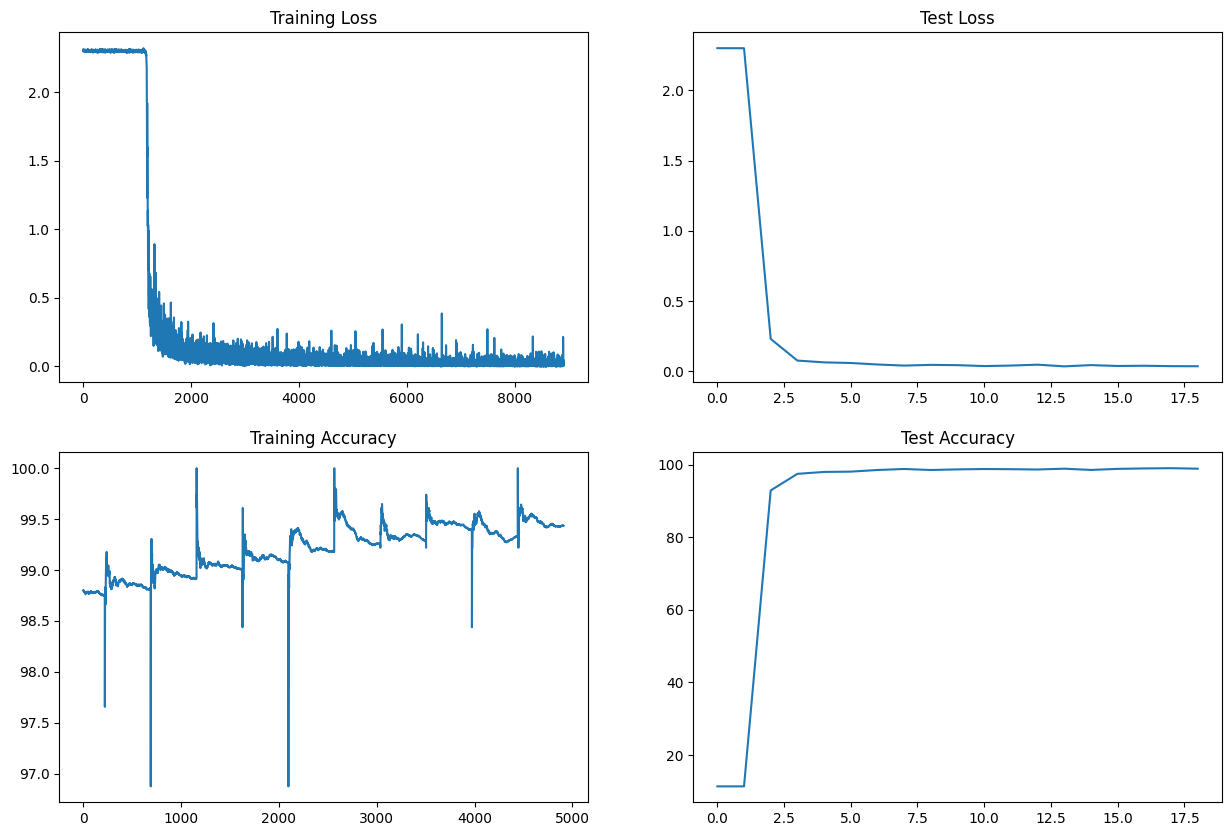

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")